# REFINAMIENTO DEL DATASET

In [1]:
import pandas as pd

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    return None

dataset = pd.read_csv('./games_data_processed.csv', sep=',', usecols=lambda column: column not in ['steamId', 'name', 'developers', 'features', 'tags'])

df = dataset.copy()

df.drop_duplicates(keep=False, inplace=True)
df.dropna(subset=['releaseDate'], inplace=True)

# Se filtran los juegos con menos de 30 ventas y mayores a 30.000 ventas (8%-96%) del mercado como lo indica Video Game Insights
df = df[df['copiesSold'] >= 30]
df= df[df["copiesSold"] <= 30000]

publisher_review_counts = df.groupby('publishers')['copiesSold'].mean().reset_index()
publisher_review_counts.columns = ['publishers', 'avg_publisher_copies']

df = df.merge(publisher_review_counts, on='publishers', how='left')
df = df[df['avg_publisher_copies'].notna()]

df['releaseDate'] = pd.to_datetime(df['releaseDate'], format='%m/%Y', errors='coerce')
df['year'] = df['releaseDate'].dt.year
df['month'] = df['releaseDate'].dt.month
df['season'] = df['month'].apply(get_season)

df = df.drop(['releaseDate', 'month'], axis=1)
undesired_genres = ['Accounting', 'Animation & Modeling', 'Audio Production', 'Design & Illustration', 'Game Development', 'Movie', 'Software Training', 'Utilities', 'Video Production', 'Web Publishing']
for genre in undesired_genres:
    df = df[~df['genres'].str.contains(genre, case=False)]

genres_encoded = df['genres'].str.replace(', ', '|').str.get_dummies()
df = pd.concat([df, genres_encoded], axis=1)
df = df.drop('genres', axis=1)

# Se guarda el DataFrame con los datos procesados en un archivo CSV
df.to_csv('games_data_refined.csv', index=False)
print("El DataFrame refinado ha sido guardado como 'games_data_refined.csv'.")

df.head()


El DataFrame refinado ha sido guardado como 'games_data_refined.csv'.


,price,reviews,reviewScore,copiesSold,publishers,avg_publisher_copies,year,season,Action,Adventure,...,Early Access,Education,Free to Play,Indie,Massively Multiplayer,RPG,Racing,Simulation,Sports,Strategy
0,0.00,139,65,9770,Lucky Cat Studio,9770.000000,2021,Fall,0,1,...,0,0,1,0,1,1,0,0,0,0
1,0.00,319,69,16799,Starlight Games,9124.500000,2023,Winter,0,0,...,0,0,0,0,1,1,1,1,0,1
2,89.99,446,70,20943,Cinematography Database,11204.000000,2018,Fall,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0.00,619,38,18933,Starlight Games,9124.500000,2023,Fall,1,1,...,0,0,1,0,1,1,1,0,0,1
4,59.99,704,95,27394,"NIS America, Inc.",10021.378378,2023,Summer,0,0,...,0,0,0,0,0,1,0,0,0,0


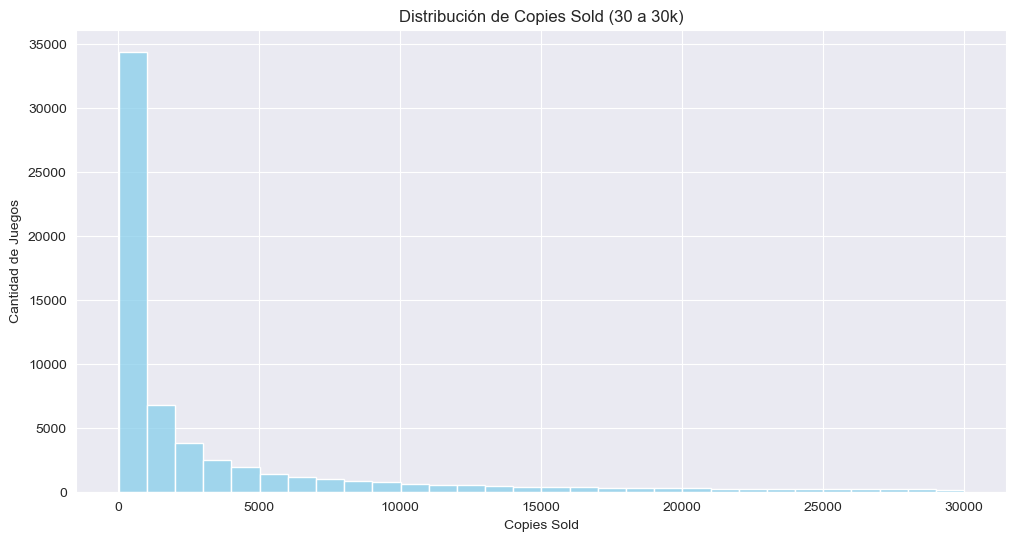

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

sns.histplot(df['copiesSold'], bins=30, kde=False, color='skyblue')
plt.title('Distribución de Copies Sold (30 a 30k)')
plt.xlabel('Copies Sold')
plt.ylabel('Cantidad de Juegos')
plt.show()


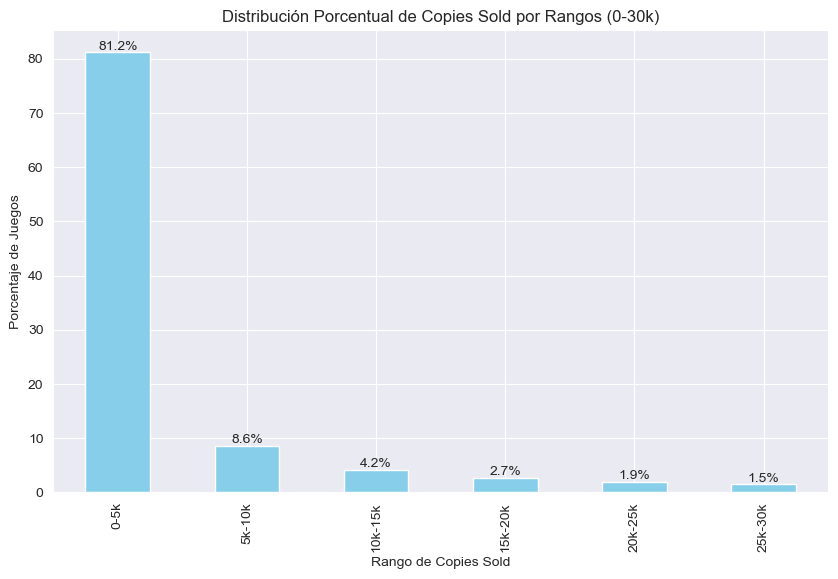

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

bins = [0, 5000, 10000, 15000, 20000, 25000, 30000]
labels = ['0-5k', '5k-10k', '10k-15k', '15k-20k', '20k-25k', '25k-30k']

rango_temp = pd.cut(df['copiesSold'], bins=bins, labels=labels, right=False)

rango_counts = rango_temp.value_counts(normalize=True) * 100
rango_counts = rango_counts.sort_index()

plt.figure(figsize=(10, 6))
rango_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución Porcentual de Copies Sold por Rangos (0-30k)')
plt.xlabel('Rango de Copies Sold')
plt.ylabel('Porcentaje de Juegos')

for i, v in enumerate(rango_counts):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center')

plt.show()


In [4]:
print("Longitud del Dataset: ",len(df))

print("Maximo valor de copias vendidas: ",max(df["copiesSold"]))

print("Minimo valor de copias vendidas: ",min(df["copiesSold"]))

df.columns

Longitud del Dataset:  60790
Maximo valor de copias vendidas:  29997
Minimo valor de copias vendidas:  30


Index(['price', 'reviews', 'reviewScore', 'copiesSold', 'publishers',
       'avg_publisher_copies', 'year', 'season', 'Action', 'Adventure',
       'Casual', 'Early Access', 'Education', 'Free to Play', 'Indie',
       'Massively Multiplayer', 'RPG', 'Racing', 'Simulation', 'Sports',
       'Strategy'],
      dtype='object')

# ENTRENAMIENTO DE MODELOS: 
- RANDOM FOREST 
- XGBOOST 
- GRADIENT BOOST
### STACKING REGRESSOR PARA JUNTAR A LOS 3 MODELOS
 

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib
import time

# Se divide el conjunto de datos: 90% entrenamiento, 5% desarrollo, 5% prueba
print("Dividiendo el conjunto de datos...")
X = df.drop(['copiesSold'], axis=1)
y = df['copiesSold']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.10, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print(f'Tamaño del conjunto de entrenamiento: {len(X_train)}')
print(f'Tamaño del conjunto de desarrollo: {len(X_dev)}')
print(f'Tamaño del conjunto de prueba: {len(X_test)}')

categorical_features = ['season', 'publishers']
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.difference(['copiesSold', 'year'])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__min_samples_leaf': [1, 2, 4]
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())
])

print("Iniciando la búsqueda de hiperparámetros...")
start_time = time.time()

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

end_time = time.time()
execution_time = end_time - start_time

best_pipeline = grid_search.best_estimator_

print("Evaluando el mejor modelo en el conjunto de prueba...")
y_test_pred = best_pipeline.predict(X_test)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f'\nMétricas del mejor modelo en prueba:')
print(f'R² en prueba: {r2_test}')
print(f'MSE en prueba: {mse_test}')
print(f'MAE en prueba: {mae_test}')

best_params = grid_search.best_params_
print(f'\nMejores parámetros encontrados: {best_params}')

# Se guarda el mejor modelo
print("Guardando el mejor modelo...")
joblib.dump(best_pipeline, 'Models/model_rf.pkl')

print(f"Tiempo total de ejecución: {execution_time:.2f} segundos")


Dividiendo el conjunto de datos...
Tamaño del conjunto de entrenamiento: 54711
Tamaño del conjunto de desarrollo: 3039
Tamaño del conjunto de prueba: 3040
Iniciando la búsqueda de hiperparámetros...
Evaluando el mejor modelo en el conjunto de prueba...

Métricas del mejor modelo en prueba:
R² en prueba: 0.8599732941359493
MSE en prueba: 4432584.235450183
MAE en prueba: 928.4843973764614

Mejores parámetros encontrados: {'model__max_depth': 7, 'model__min_samples_leaf': 4, 'model__n_estimators': 200}
Guardando el mejor modelo...
Tiempo total de ejecución: 684.12 segundos


In [6]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib
import time

# Se divide el conjunto de datos: 90% entrenamiento, 5% desarrollo, 5% prueba
print("Dividiendo el conjunto de datos...")
X = df.drop(['copiesSold'], axis=1)
y = df['copiesSold']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.10, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print(f'Tamaño del conjunto de entrenamiento: {len(X_train)}')
print(f'Tamaño del conjunto de desarrollo: {len(X_dev)}')
print(f'Tamaño del conjunto de prueba: {len(X_test)}')

categorical_features = ['season', 'publishers']
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.difference(['copiesSold', 'year'])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.8, 0.9, 1.0]
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor())
])

print("Iniciando la búsqueda de hiperparámetros...")
start_time = time.time()

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

end_time = time.time()
execution_time = end_time - start_time

best_pipeline = grid_search.best_estimator_

print("Evaluando el mejor modelo en el conjunto de prueba...")
y_test_pred = best_pipeline.predict(X_test)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f'\nMétricas del mejor modelo en prueba:')
print(f'R² en prueba: {r2_test}')
print(f'MSE en prueba: {mse_test}')
print(f'MAE en prueba: {mae_test}')

best_params = grid_search.best_params_
print(f'\nMejores parámetros encontrados: {best_params}')

# Se guarda el mejor modelo
print("Guardando el mejor modelo...")
joblib.dump(best_pipeline, 'Models/model_xgb.pkl')

print(f"Tiempo total de ejecución: {execution_time:.2f} segundos")


Dividiendo el conjunto de datos...
Tamaño del conjunto de entrenamiento: 54711
Tamaño del conjunto de desarrollo: 3039
Tamaño del conjunto de prueba: 3040
Iniciando la búsqueda de hiperparámetros...
Evaluando el mejor modelo en el conjunto de prueba...

Métricas del mejor modelo en prueba:
R² en prueba: 0.8785741987258107
MSE en prueba: 3843767.438387331
MAE en prueba: 865.1555318167335

Mejores parámetros encontrados: {'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__n_estimators': 200, 'model__subsample': 0.8}
Guardando el mejor modelo...
Tiempo total de ejecución: 446.11 segundos


In [7]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib
import time

# Se divide el conjunto de datos: 90% entrenamiento, 5% desarrollo, 5% prueba
print("Dividiendo el conjunto de datos...")
X = df.drop(['copiesSold'], axis=1)
y = df['copiesSold']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.10, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print(f'Tamaño del conjunto de entrenamiento: {len(X_train)}')
print(f'Tamaño del conjunto de desarrollo: {len(X_dev)}')
print(f'Tamaño del conjunto de prueba: {len(X_test)}')

categorical_features = ['season', 'publishers']
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.difference(['copiesSold', 'year'])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__min_samples_leaf': [1, 2, 4]
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor())
])

print("Iniciando la búsqueda de hiperparámetros...")
start_time = time.time()

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

end_time = time.time()
execution_time = end_time - start_time

best_pipeline = grid_search.best_estimator_

print("Evaluando el mejor modelo en el conjunto de prueba...")
y_test_pred = best_pipeline.predict(X_test)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f'\nMétricas del mejor modelo en prueba:')
print(f'R² en prueba: {r2_test}')
print(f'MSE en prueba: {mse_test}')
print(f'MAE en prueba: {mae_test}')

best_params = grid_search.best_params_
print(f'\nMejores parámetros encontrados: {best_params}')

# Se guarda el mejor modelo
print("Guardando el mejor modelo...")
joblib.dump(best_pipeline, 'Models/model_gbt.pkl')

print(f"Tiempo total de ejecución: {execution_time:.2f} segundos")


Dividiendo el conjunto de datos...
Tamaño del conjunto de entrenamiento: 54711
Tamaño del conjunto de desarrollo: 3039
Tamaño del conjunto de prueba: 3040
Iniciando la búsqueda de hiperparámetros...
Evaluando el mejor modelo en el conjunto de prueba...

Métricas del mejor modelo en prueba:
R² en prueba: 0.8776987339496006
MSE en prueba: 3871480.5188441994
MAE en prueba: 854.4457906405829

Mejores parámetros encontrados: {'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__min_samples_leaf': 4, 'model__n_estimators': 300}
Guardando el mejor modelo...
Tiempo total de ejecución: 1670.59 segundos


In [8]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import time

# Se cargan los modelos previamente entrenados
print("Cargando modelos...")
model_rf = joblib.load('Models/model_rf.pkl')
model_xgb = joblib.load('Models/model_xgb.pkl')
model_gbt = joblib.load('Models/model_gbt.pkl')

estimators = [
    ('rf', model_rf.named_steps['model']),
    ('xgb', model_xgb.named_steps['model']),
    ('gbt', model_gbt.named_steps['model'])
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge()
)

print("Preprocesando los datos...")
X = df.drop(['copiesSold'], axis=1)
y = df['copiesSold']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.10, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print("Entrenando el modelo de Stacking...")
start_time = time.time()

pipeline = Pipeline(steps=[
    ('preprocessor', model_rf.named_steps['preprocessor']),
    ('stacking_model', stacking_model)
])

pipeline.fit(X_train, y_train)

end_time = time.time()
execution_time = end_time - start_time

print("Evaluando el modelo de Stacking en el conjunto de prueba...")
y_test_pred = pipeline.predict(X_test)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f'\nMétricas del modelo de Stacking en prueba:')
print(f'R² en prueba: {r2_test}')
print(f'MSE en prueba: {mse_test}')
print(f'MAE en prueba: {mae_test}')

# Se guarda el modelo de Stacking
print("Guardando el modelo de Stacking...")
joblib.dump(pipeline, 'Models/model_best_stacking.pkl')

print(f"Tiempo total de ejecución: {execution_time:.2f} segundos")


Cargando modelos...
Preprocesando los datos...
Entrenando el modelo de Stacking...
Evaluando el modelo de Stacking en el conjunto de prueba...

Métricas del modelo de Stacking en prueba:
R² en prueba: 0.8795425262910416
MSE en prueba: 3813114.7605719897
MAE en prueba: 851.3653923615893
Guardando el modelo de Stacking...
Tiempo total de ejecución: 4970.84 segundos


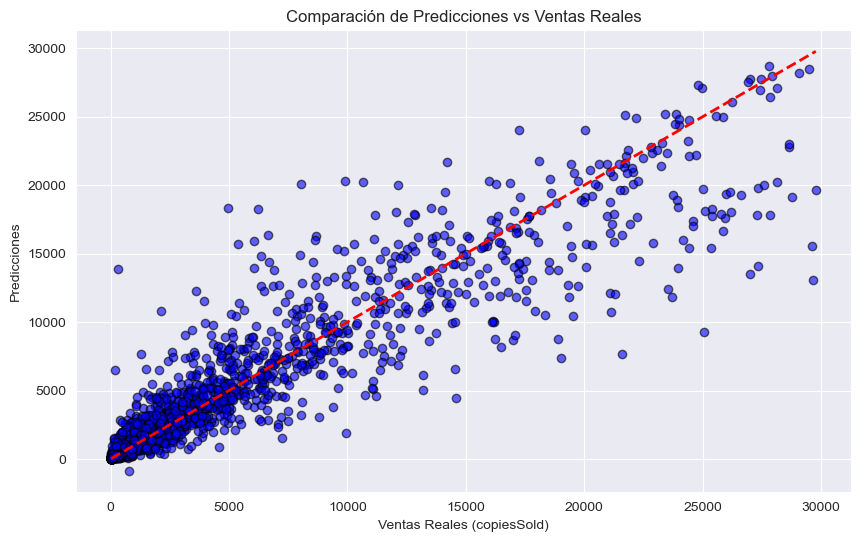

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='b', edgecolor='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.title('Comparación de Predicciones vs Ventas Reales')
plt.xlabel('Ventas Reales (copiesSold)')
plt.ylabel('Predicciones')
plt.show()


In [11]:
len(y_test)

3040

In [12]:
df.head()

,price,reviews,reviewScore,copiesSold,publishers,avg_publisher_copies,year,season,Action,Adventure,...,Early Access,Education,Free to Play,Indie,Massively Multiplayer,RPG,Racing,Simulation,Sports,Strategy
0,0.00,139,65,9770,Lucky Cat Studio,9770.000000,2021,Fall,0,1,...,0,0,1,0,1,1,0,0,0,0
1,0.00,319,69,16799,Starlight Games,9124.500000,2023,Winter,0,0,...,0,0,0,0,1,1,1,1,0,1
2,89.99,446,70,20943,Cinematography Database,11204.000000,2018,Fall,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0.00,619,38,18933,Starlight Games,9124.500000,2023,Fall,1,1,...,0,0,1,0,1,1,1,0,0,1
4,59.99,704,95,27394,"NIS America, Inc.",10021.378378,2023,Summer,0,0,...,0,0,0,0,0,1,0,0,0,0


In [18]:
import joblib

# Se carga y utiliza el modelo de Stacking Regressor para realizar las predicciones
model_stacking = joblib.load('Models/model_best_stacking.pkl')

# Nombre del publisher a buscar, en este caso uno nuevo de prueba, existentes = Electronic Arts, ACTION SQUARE, etc
publisher_name = "Testeo Nuevo Publisher"  

if publisher_name in df['publishers'].values:
    publisher_data = df[df['publishers'] == publisher_name].select_dtypes(include=['number']).mean()
    avg_reviews = publisher_data['reviews']
    avg_review_score = publisher_data['reviewScore']
    avg_publisher_copies = publisher_data['avg_publisher_copies']
else:
    # Datos para un nuevo publisher: 5 reseñas en promedio, con 80% de score positivo y 100 copias vendidas promedio
    avg_reviews = 5  
    avg_review_score = 80  
    avg_publisher_copies = 100  

# Se crea un nuevo juego con datos ficticios basados en el publisher a modo de prueba, editables para probar distintas predicciones: 1 si contiene ese valor, sino se usa 0
new_game = {
    'price': 19.99, # Siempre es 0 en caso de que un juego sea Free to Play, caso contrario se utilizan generalmente con 99 centimos, por ejemplo: 19.99
    'reviews': avg_reviews,  
    'reviewScore': avg_review_score,  
    'publishers': publisher_name,  
    'avg_publisher_copies': avg_publisher_copies,  
    'season': 'Fall',
    'Action': 0,
    'Adventure': 1,
    'Casual': 0,
    'Early Access': 0,
    'Education': 0,
    'Free to Play': 0,
    'Indie': 0,
    'Massively Multiplayer': 0,
    'RPG': 1,
    'Racing': 0,
    'Simulation': 0,
    'Sports': 0,
    'Strategy': 0
}

new_game_df = pd.DataFrame([new_game])

# Se realiza la predicción
predicted_sales = model_stacking.predict(new_game_df)

print(f"Predicción de ventas para el juego nuevo: {predicted_sales[0]:.2f} copias")


Predicción de ventas para el juego nuevo: 85.10 copias
